In [9]:
import pandas as pd
import seaborn as sb
import warnings
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_csv('data_warehouse/sleep_to_performance.csv')
warnings.filterwarnings('ignore')
df.head()

,Timestamp,1. What is your year of study?,2. What is your gender?,3. How often do you have difficulty falling asleep at night?,"4. On average, how many hours of sleep do you get on a typical day?",5. How often do you wake up during the night and have trouble falling back asleep?,6. How would you rate the overall quality of your sleep?,7. How often do you experience difficulty concentrating during lectures or studying due to lack of sleep?,"8. How often do you feel fatigued during the day, affecting your ability to study or attend classes?","9. How often do you miss or skip classes due to sleep-related issues (e.g., insomnia, feeling tired)?",10. How would you describe the impact of insufficient sleep on your ability to complete assignments and meet deadlines?,"11. How often do you use electronic devices (e.g., phone, computer) before going to sleep?","12. How often do you consume caffeine (coffee, energy drinks) to stay awake or alert?",13. How often do you engage in physical activity or exercise?,14. How would you describe your stress levels related to academic workload?,15. How would you rate your overall academic performance (GPA or grades) in the past semester?
0,10/24/2024 16:51:15,Graduate student,Male,Often (5-6 times a week),7-8 hours,Often (5-6 times a week),Good,Sometimes,Often,Often (3-4 times a week),Moderate impact,Often (5-6 times a week),Rarely (1-2 times a week),Sometimes (3-4 times a week),High stress,Average
1,10/24/2024 16:51:51,Third year,Male,Often (5-6 times a week),7-8 hours,Often (5-6 times a week),Good,Often,Sometimes,Sometimes (1-2 times a week),Major impact,Sometimes (3-4 times a week),Sometimes (3-4 times a week),Sometimes (3-4 times a week),Low stress,Good
2,10/24/2024 16:52:21,First year,Female,Sometimes (3-4 times a week),7-8 hours,Sometimes (3-4 times a week),Good,Often,Often,Sometimes (1-2 times a week),Major impact,Often (5-6 times a week),Often (5-6 times a week),Often (5-6 times a week),High stress,Below Average
3,10/24/2024 16:53:00,Third year,Male,Often (5-6 times a week),More than 8 hours,Sometimes (3-4 times a week),Poor,Often,Often,Rarely (1-2 times a month),Minor impact,Sometimes (3-4 times a week),Sometimes (3-4 times a week),Every day,Extremely high stress,Excellent
4,10/24/2024 16:53:25,Graduate student,Male,Often (5-6 times a week),7-8 hours,Often (5-6 times a week),Very good,Always,Sometimes,Sometimes (1-2 times a week),Moderate impact,Sometimes (3-4 times a week),Sometimes (3-4 times a week),Often (5-6 times a week),Low stress,Average


**EDA**

In [10]:
df.describe()
# Loai bo cot
# df = df.drop(columns=["Timestamp"])
df.columns


Index(['Timestamp', '1. What is your year of study?',
       '2. What is your gender?',
       '3. How often do you have difficulty falling asleep at night? ',
       '4. On average, how many hours of sleep do you get on a typical day?',
       '5. How often do you wake up during the night and have trouble falling back asleep?',
       '6. How would you rate the overall quality of your sleep?',
       '7. How often do you experience difficulty concentrating during lectures or studying due to lack of sleep?',
       '8. How often do you feel fatigued during the day, affecting your ability to study or attend classes?',
       '9. How often do you miss or skip classes due to sleep-related issues (e.g., insomnia, feeling tired)?',
       '10. How would you describe the impact of insufficient sleep on your ability to complete assignments and meet deadlines?',
       '11. How often do you use electronic devices (e.g., phone, computer) before going to sleep?',
       '12. How often do you con

In [11]:
df.rename(columns={
    '1. What is your year of study?':'study_year',
    '2. What is your gender?': 'gender',
    '3. How often do you have difficulty falling asleep at night? ':'freq_hard_falling_sleep',
    '4. On average, how many hours of sleep do you get on a typical day?': 'avg_sleeptime_a_day',
    '5. How often do you wake up during the night and have trouble falling back asleep?':'freq_insomnia',
    '6. How would you rate the overall quality of your sleep?':'sleep_rating',
    '7. How often do you experience difficulty concentrating during lectures or studying due to lack of sleep?':'freq_focus_difficulty',
    '8. How often do you feel fatigued during the day, affecting your ability to study or attend classes?':'freq_fatigued',
    '9. How often do you miss or skip classes due to sleep-related issues (e.g., insomnia, feeling tired)?':'freq_attendance',
    '10. How would you describe the impact of insufficient sleep on your ability to complete assignments and meet deadlines?':'task_completion_impact',
    '11. How often do you use electronic devices (e.g., phone, computer) before going to sleep?': 'device_usage_before_bedtime',
    '12. How often do you consume caffeine (coffee, energy drinks) to stay awake or alert?':'caffeine_intake',
    '13. How often do you engage in physical activity or exercise?':'freq_physical_activity',
    '14. How would you describe your stress levels related to academic workload?':'stress_rate',
    '15. How would you rate your overall academic performance (GPA or grades) in the past semester?':'gpa_rate'
    },inplace=True)
df.columns

Index(['Timestamp', 'study_year', 'gender', 'freq_hard_falling_sleep',
       'avg_sleeptime_a_day', 'freq_insomnia', 'sleep_rating',
       'freq_focus_difficulty', 'freq_fatigued', 'freq_attendance',
       'task_completion_impact', 'device_usage_before_bedtime',
       'caffeine_intake', 'freq_physical_activity', 'stress_rate', 'gpa_rate'],
      dtype='object')

In [12]:
df['study_year'] = df['study_year'].replace({
    'First year': 'Undergraduate',
    'Second year': 'Undergraduate',
    'Third year': 'Undergraduate',
    'Graduate Student': 'Graduate'
})
df['gpa_rate'].replace({
    'Poor': 0,
    'Below Average': 0,
    'Average': 1,
    'Good': 2,
    'Excellent': 3
},inplace=True)
frequency_columns = [
    'freq_hard_falling_sleep',
    'freq_insomnia',
    'freq_focus_difficulty',
    'freq_fatigued',
    'device_usage_before_bedtime',
    'caffeine_intake',
    'freq_physical_activity',
    'freq_attendance'
]
# Tạo dictionary ánh xạ
frequency_mapping = {
    'Never': 'Never',
    'Rarely (1-2 times a month)': 'Rarely',
    'Rarely (1-2 times a week)': 'Rarely',
    'Sometimes (1-2 times a week)': 'Sometimes',
    'Sometimes (3-4 times a week)': 'Sometimes',
    'Often (3-4 times a week)': 'Often',
    'Often (5-6 times a week)': 'Often',
    'Every day': 'Always',
    'Every night': 'Always',
    'Always': 'Always'
}

# Áp dụng chuyển đổi cho từng cột
for col in frequency_columns:
    if col in df.columns:
        df[col] = df[col].replace(frequency_mapping)
# df.drop(columns=['Timestamp'], inplace=True)

In [13]:
# for col in df.columns:
#     print(f"Tần suất giá trị cho cột: {col}")
#     print(df[col].value_counts())
#     print("\n")
print(df['gpa_rate'].value_counts())

gpa_rate
0    879
1     76
2     29
3     12
Name: count, dtype: int64


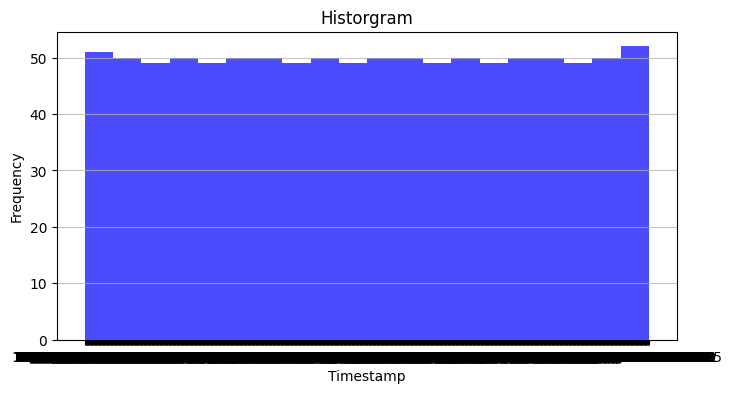

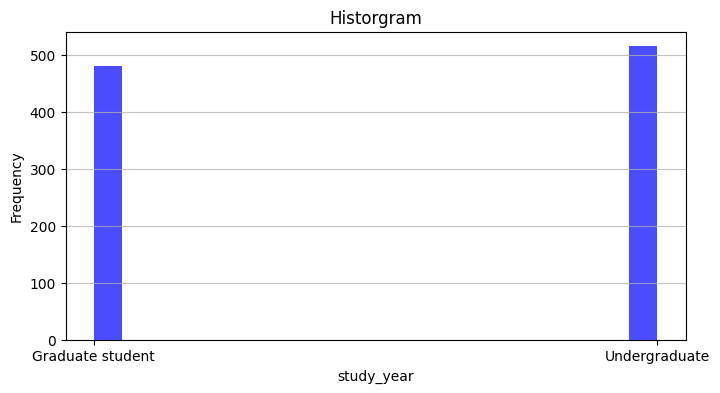

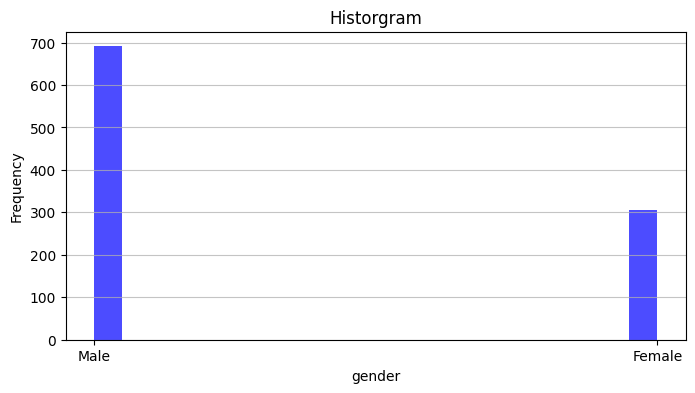

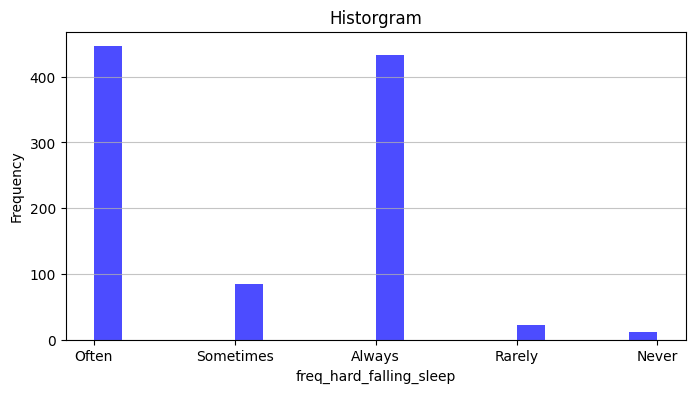

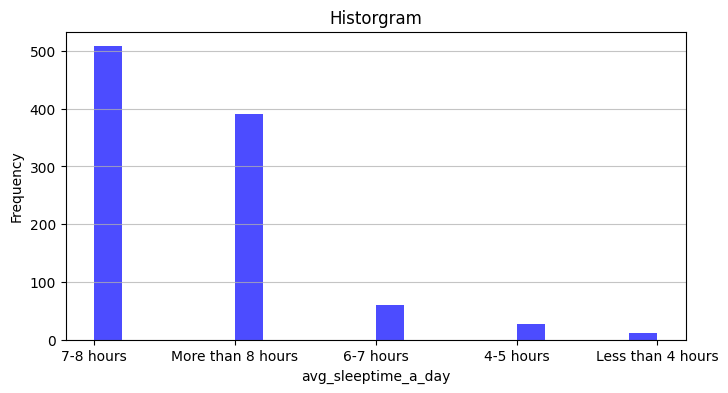

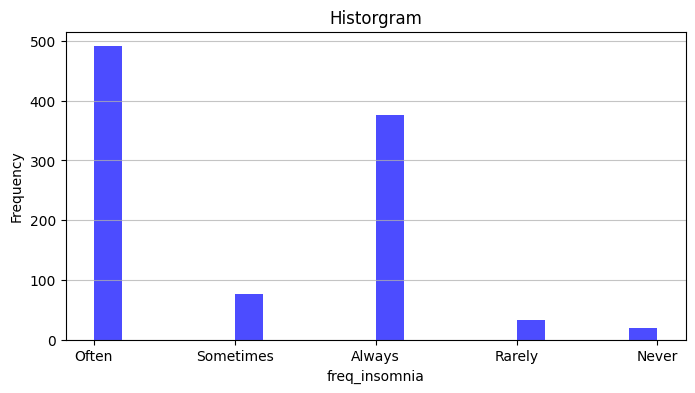

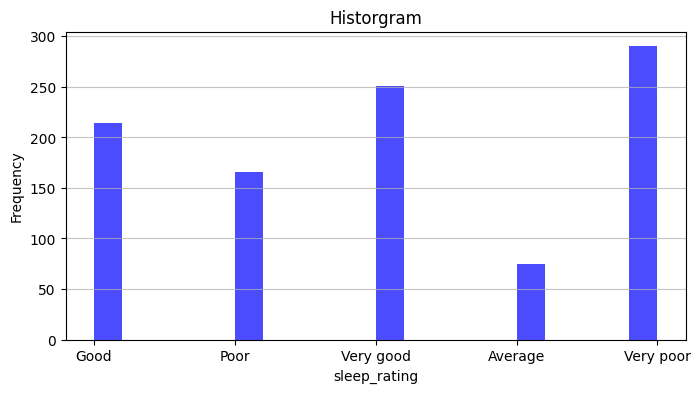

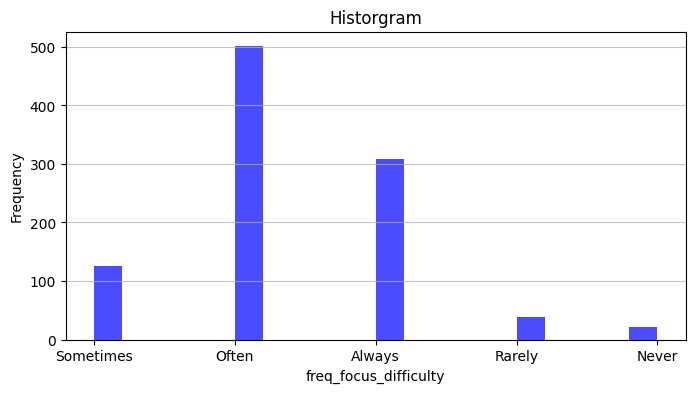

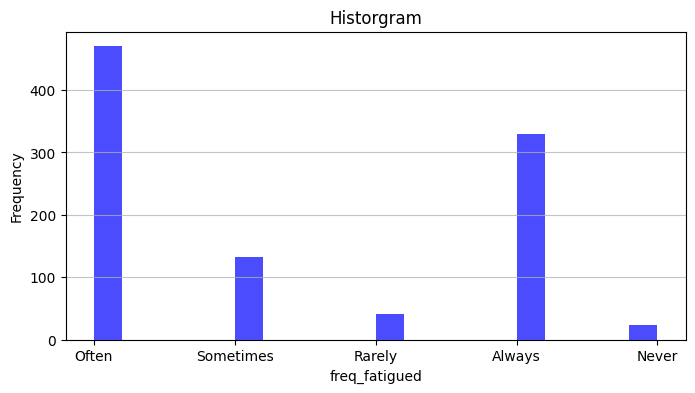

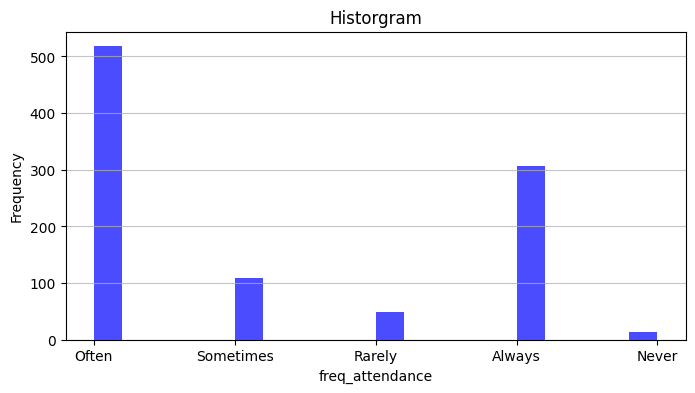

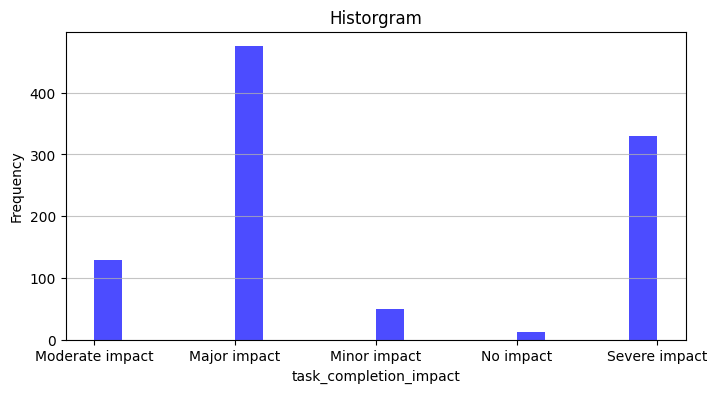

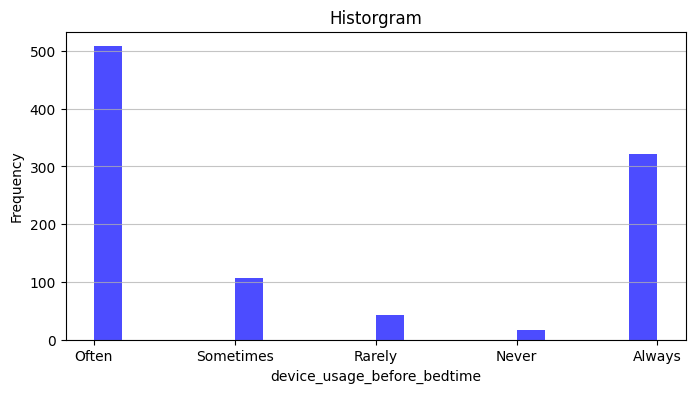

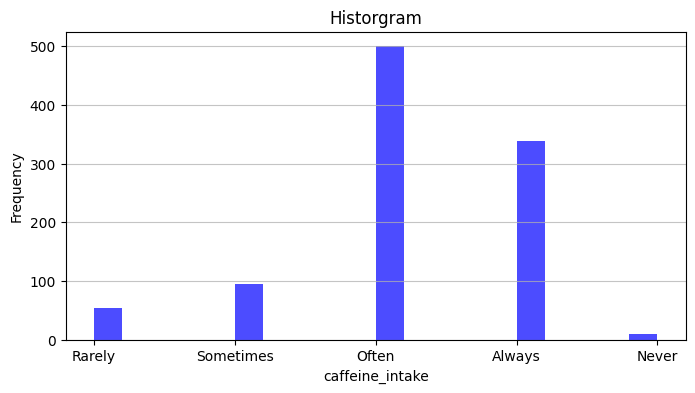

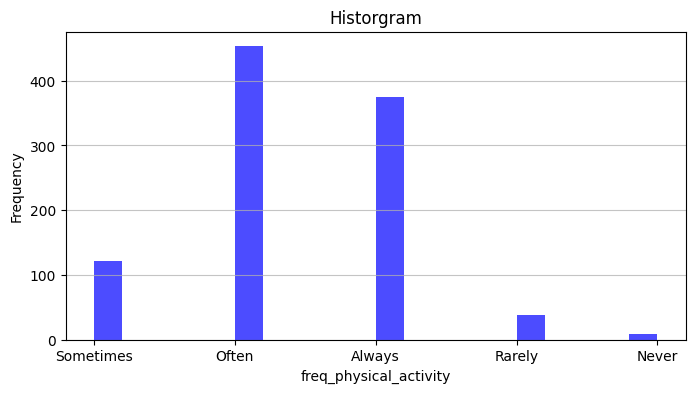

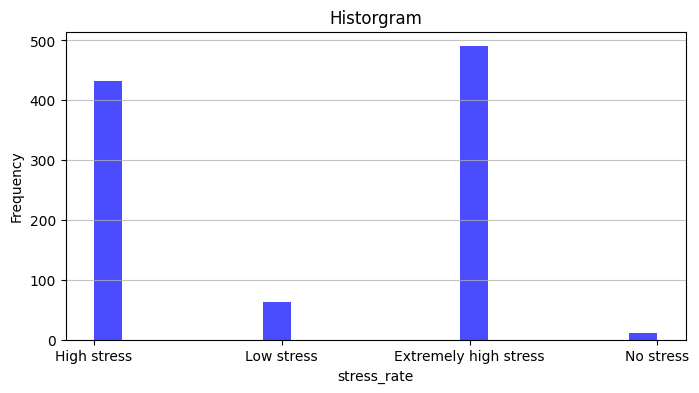

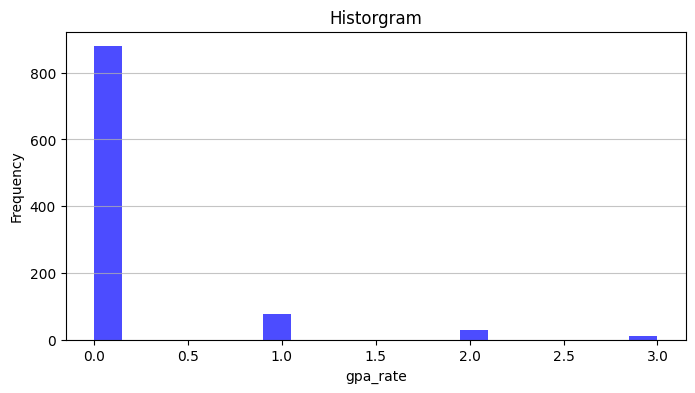

In [14]:
for col in df.columns:
    plt.figure(figsize=(8,4))
    plt.hist(df[col], bins=20, color='blue', alpha=0.7)
    plt.title(f"Historgram")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.grid(axis='y', alpha=0.75)
    plt.show()

In [15]:
"""
Những cột bị imbalanced ở đây là: 
- freq_hard_falling_sleep
- avg_sleeptime_a_day
- freq_insomnia
- freq_focus_difficulty,
- freq_fatigued
- freq_attendance
- task_completion_impact
- device_usage_before_bedtime
- stress_rate
- gpa_rate --- target
""" 
df1 = df # Handle theo hướng SMOTE + Undersampling
df2 = df # Handle t
# df1['gpa_rate'].value_counts
df1.columns
df1['stress_rate'].value_counts()

stress_rate
Extremely high stress    490
High stress              432
Low stress                63
No stress                 11
Name: count, dtype: int64

In [ ]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

    
X = df1.iloc[:, 3: 15]
Y = df1['gpa_rate'] # gpa_rate
freq_order = ['Never', 'Rarely', 'Sometimes', 'Often', 'Always']
correct_categoricals_full = [
    # 2. freq_hard_falling_sleep (Tần suất)
    freq_order,
    # 3. avg_sleeptime_a_day (Thứ tự tăng dần)
    ['Less than 4 hours', '4-5 hours', '6-7 hours', '7-8 hours', 'More than 8 hours'],
    # 4. freq_insomnia (Tần suất)
    freq_order,
    # 5. sleep_rating (Thang đo chất lượng)
    ['Very poor', 'Poor', 'Average', 'Good', 'Very good'],
    # 6. freq_focus_difficulty (Tần suất)
    freq_order,
    # 7. freq_fatigued (Tần suất)
    freq_order,
    # 8. freq_attendance (Tần suất)
    freq_order,
    # 9. task_completion_impact (Thang đo tác động)
    ['No impact', 'Minor impact', 'Moderate impact', 'Major impact', 'Severe impact'],
    # 10. device_usage_before_bedtime (Tần suất)
    freq_order,
    # 11. caffeine_intake (Tần suất)
    freq_order,
    # 12. freq_physical_activity (Tần suất)
    freq_order,

    ['No stress', 'Low stress','High stress', 'Extremely high stress']
]
encoder = OrdinalEncoder(categories=correct_categoricals_full)
lencoder = LabelEncoder()
X_encoded = encoder.fit_transform(X)
X_encoded = np.hstack([X_encoded, np.random.rand(len(X_encoded), 1)])  # thêm 1 cột giả numeric
cate_features = list(range(X.shape[1]))  
Y_encoded = lencoder.fit_transform(Y)
lencoder.inverse_transform([0,1,2,3])


12


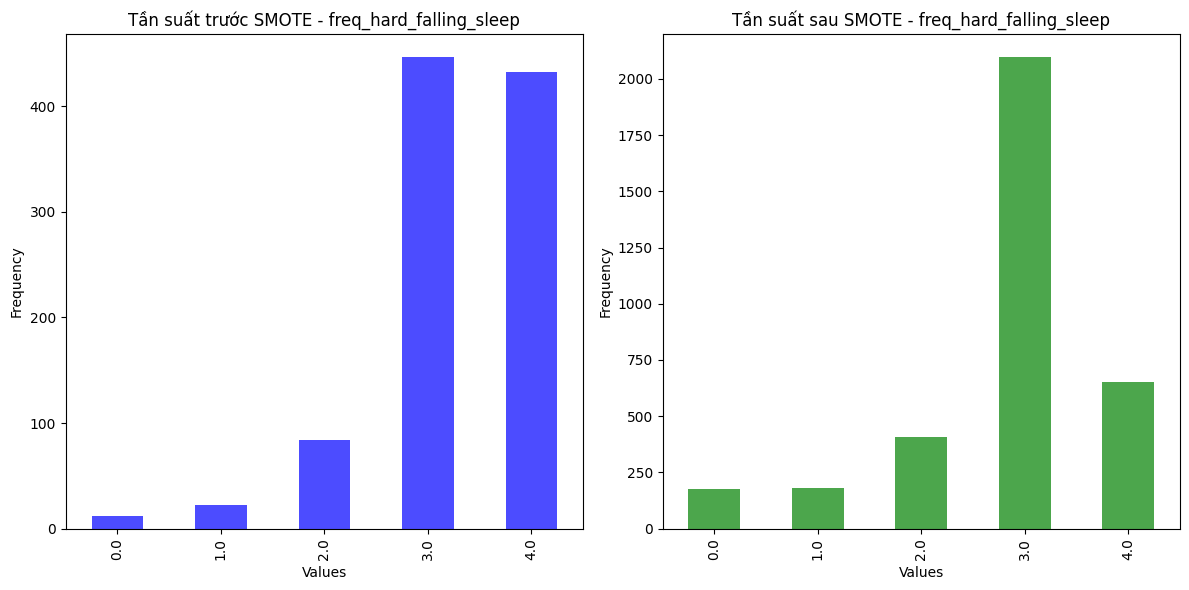

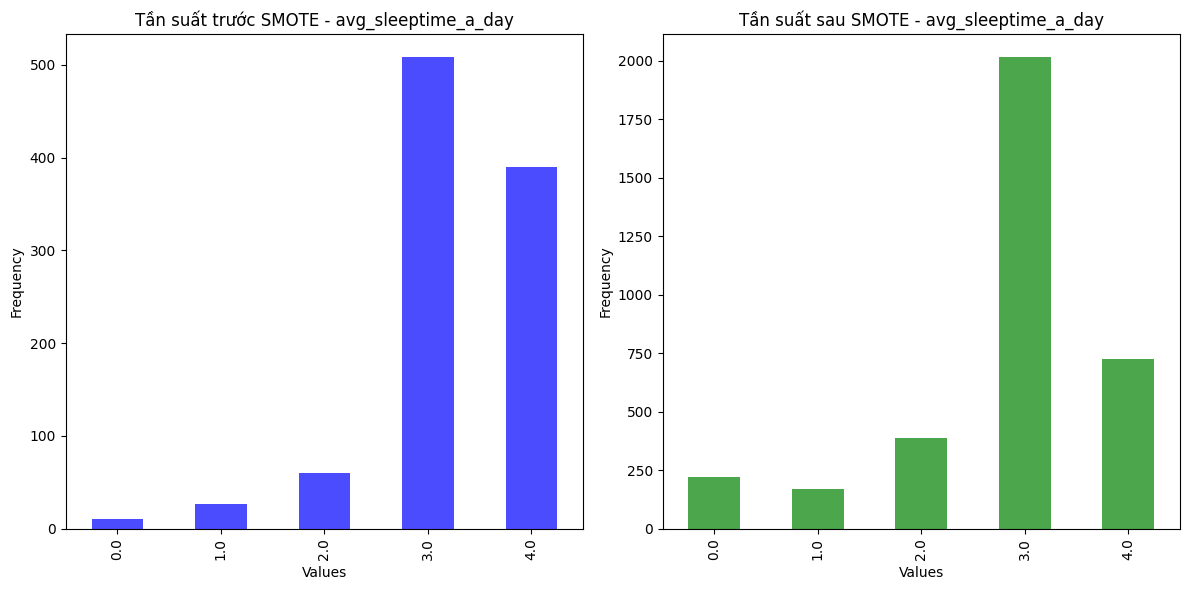

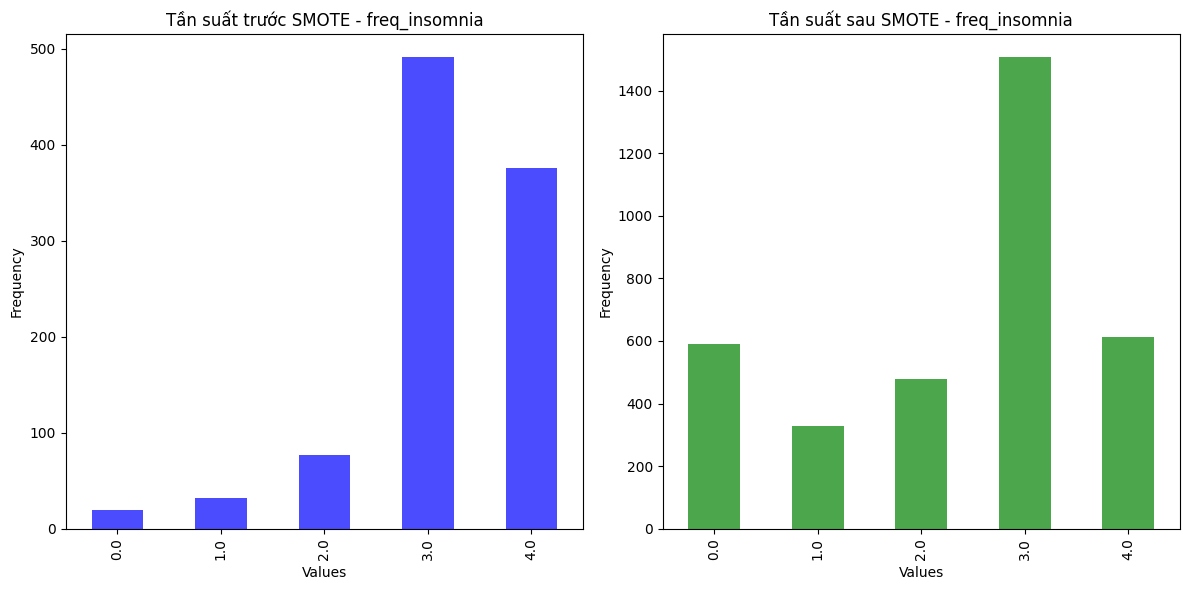

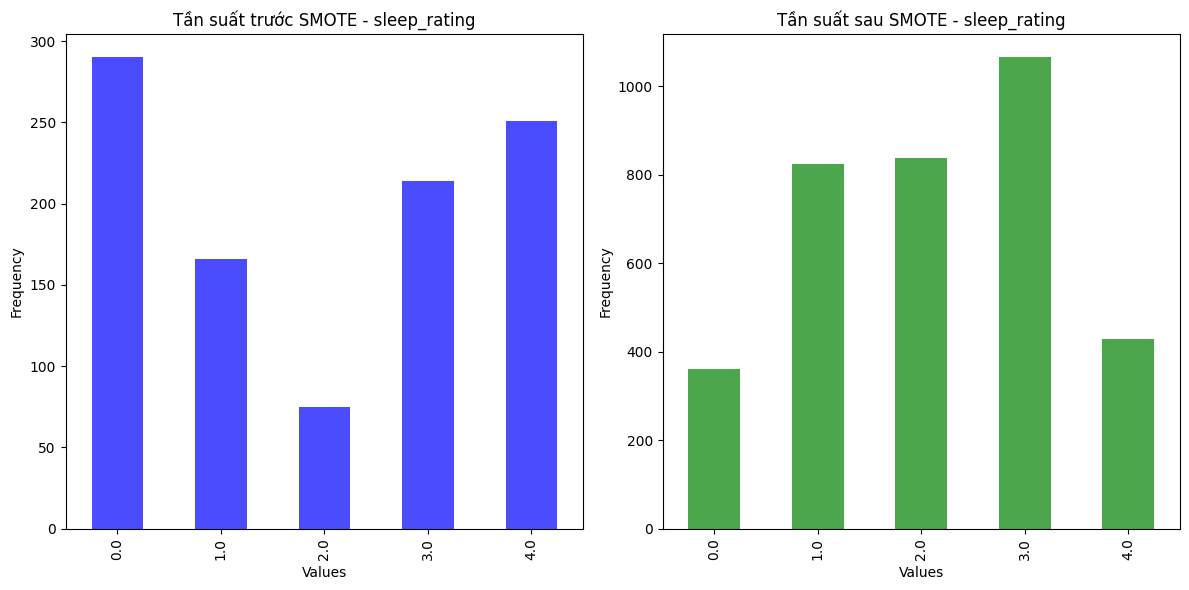

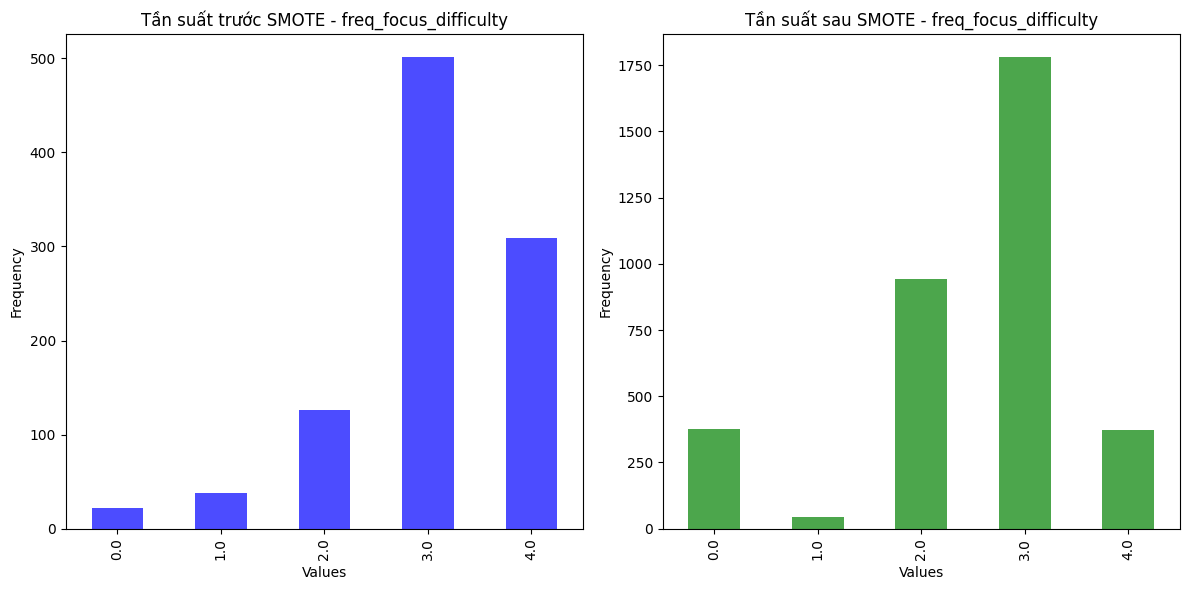

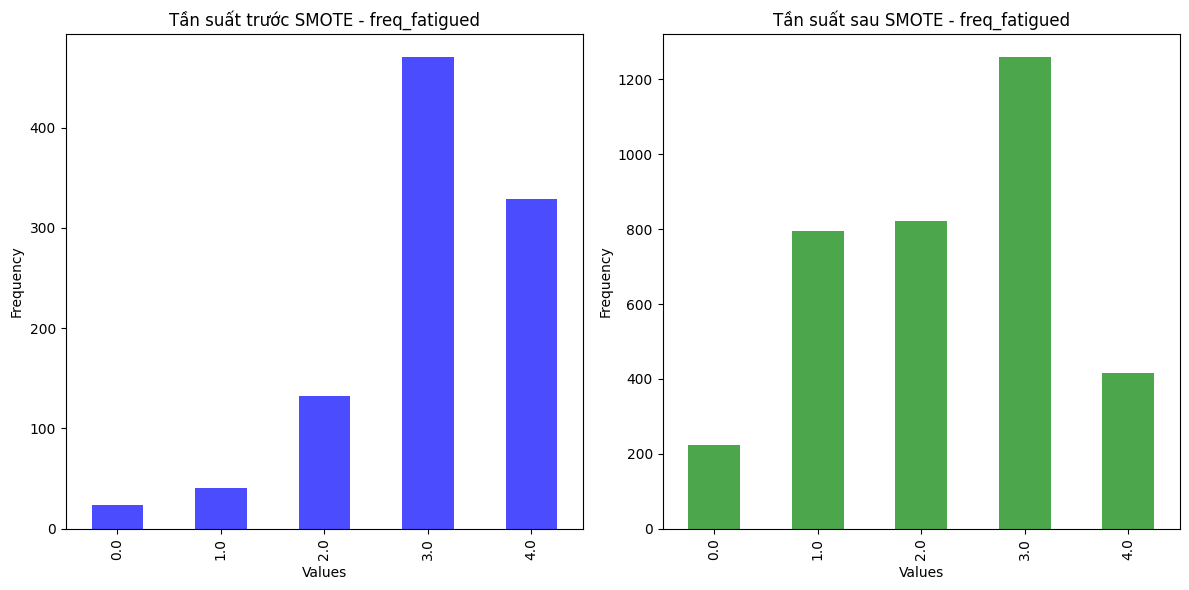

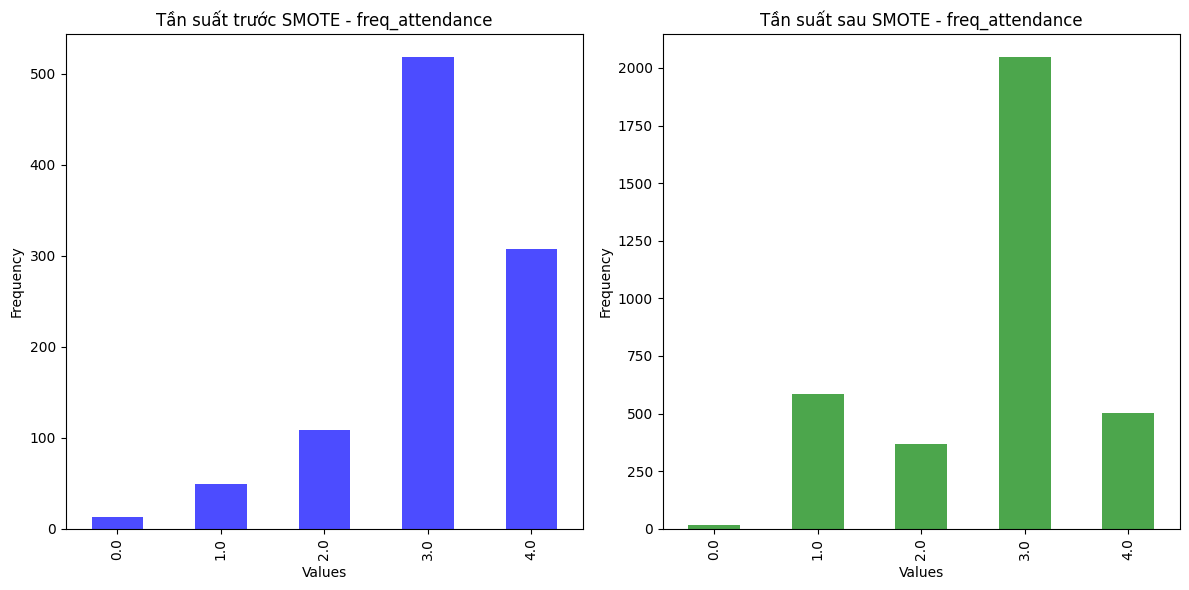

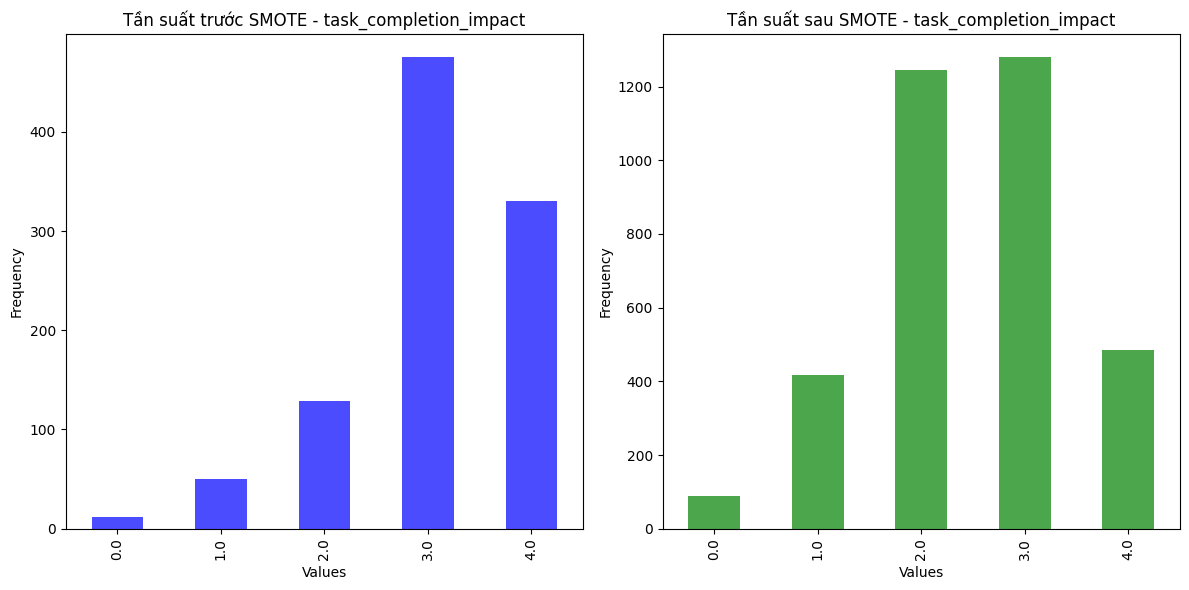

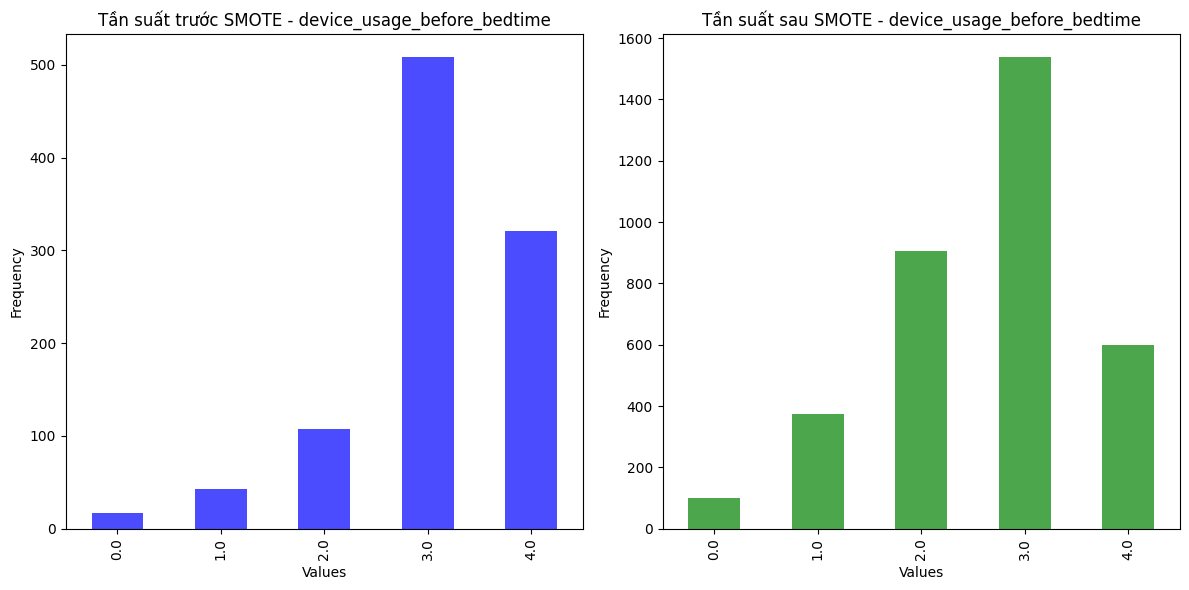

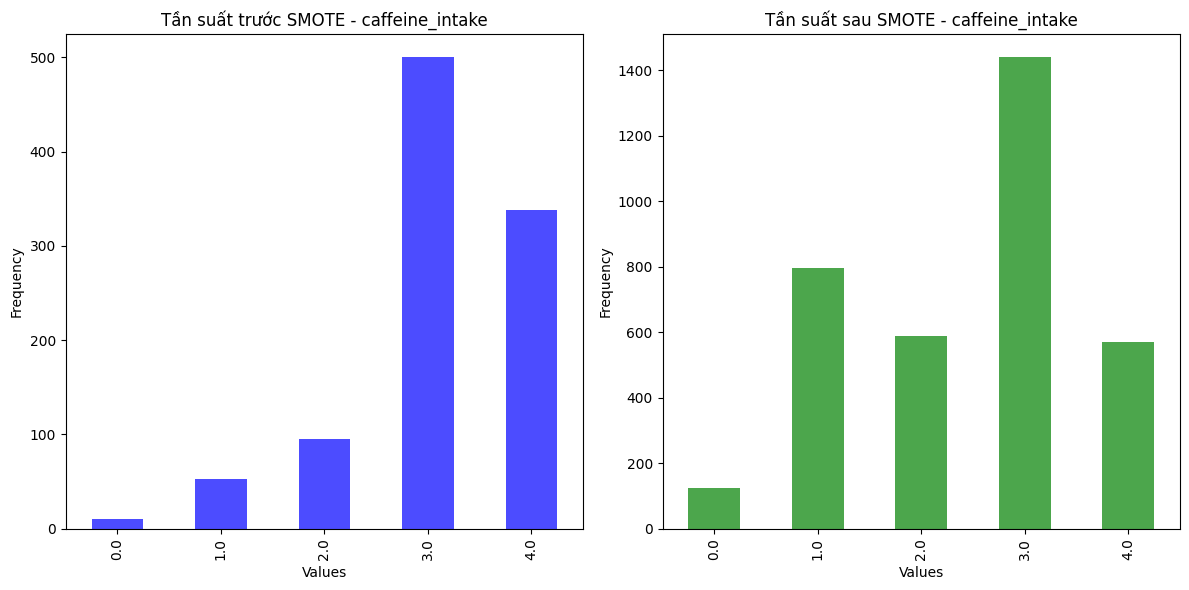

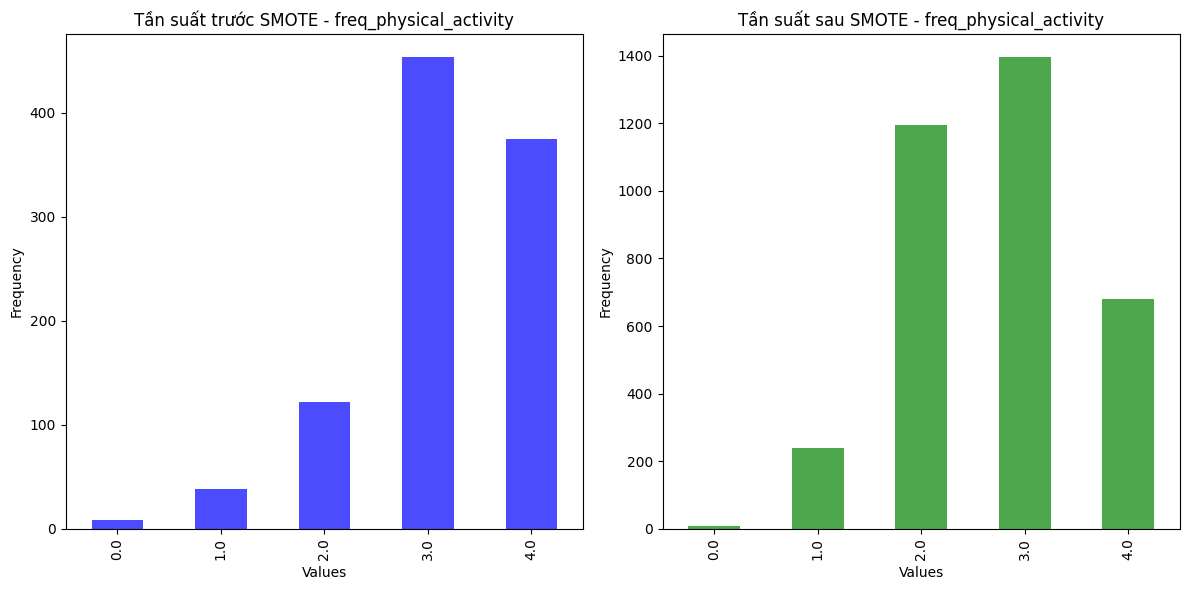

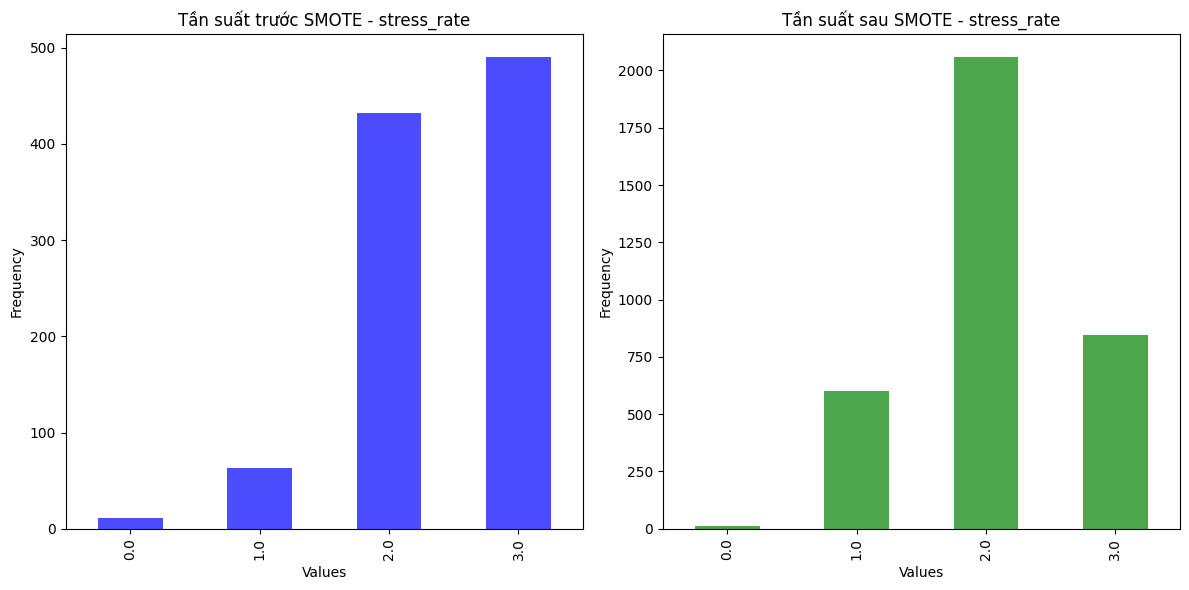

In [49]:
smote_nc = SMOTENC(categorical_features=cate_features, random_state=42)
X_res, Y_res = smote_nc.fit_resample(X_encoded, Y_encoded)
for col_idx, col_name in enumerate(X.columns):
    plt.figure(figsize=(12, 6))
    
    # Tần suất trước SMOTE
    plt.subplot(1, 2, 1)
    pd.Series(X_encoded[:, col_idx]).value_counts().sort_index().plot(kind='bar', color='blue', alpha=0.7)
    plt.title(f"Tần suất trước SMOTE - {col_name}")
    plt.xlabel("Values")
    plt.ylabel("Frequency")
    
    # Tần suất sau SMOTE
    plt.subplot(1, 2, 2)
    pd.Series(X_res[:, col_idx]).value_counts().sort_index().plot(kind='bar', color='green', alpha=0.7)
    plt.title(f"Tần suất sau SMOTE - {col_name}")
    plt.xlabel("Values")
    plt.ylabel("Frequency")
    
    plt.tight_layout()
    plt.show()

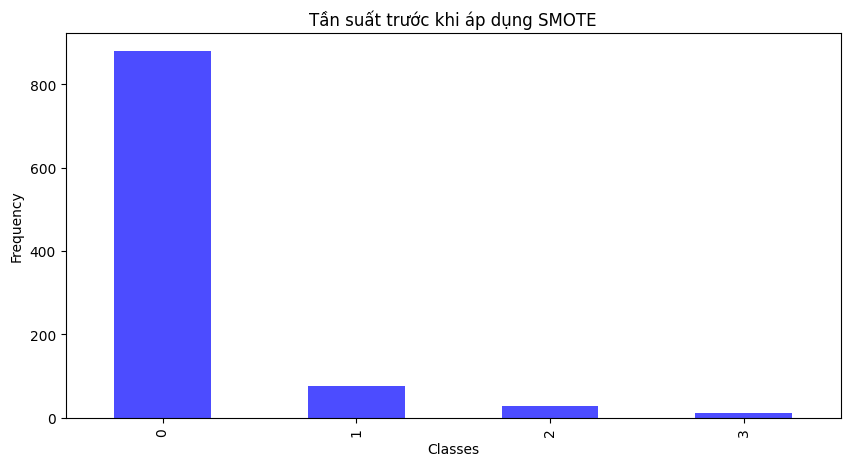

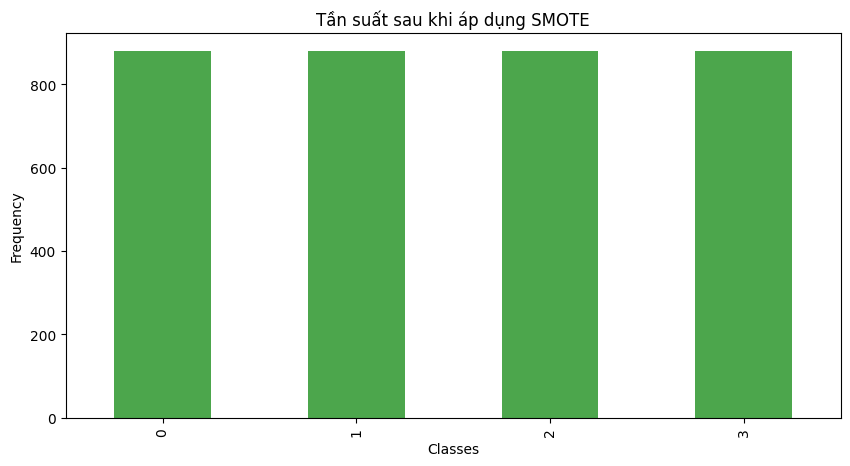

In [ ]:
# Tần suất trước SMOTE
plt.figure(figsize=(10, 5))
pd.Series(Y_encoded).value_counts().sort_index().plot(kind='bar', color='blue', alpha=0.7)
plt.title("Tần suất trước khi áp dụng SMOTE")
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.show()

# Tần suất sau SMOTE
plt.figure(figsize=(10, 5))
pd.Series(Y_res).value_counts().sort_index().plot(kind='bar', color='green', alpha=0.7)
plt.title("Tần suất sau khi áp dụng SMOTE")
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.show()


In [52]:

X_train, X_test, y_train, y_test = train_test_split(X_res, Y_res, test_size=0.2, random_state=42)
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_encoded, Y_encoded, test_size=0.2, random_state=42)

In [55]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# Huấn luyện mô hình
model_orig = RandomForestClassifier(random_state=42)
model_orig.fit(X_train_orig, y_train_orig)

# Dự đoán
y_pred_orig = model_orig.predict(X_test_orig)

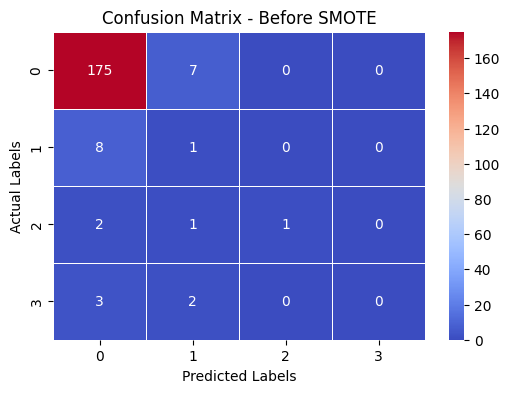

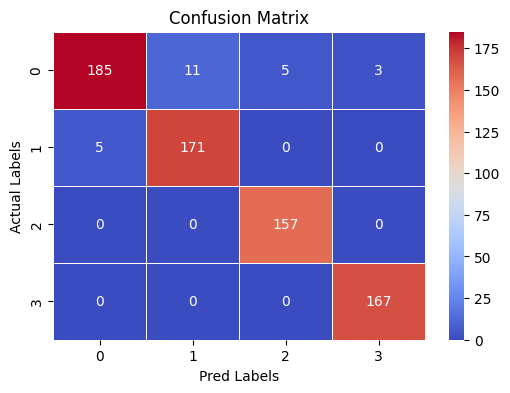

In [56]:
# Vẽ Confusion Matrix trước khi áp dụng SMOTE
conf_matrix_orig = confusion_matrix(y_test_orig, y_pred_orig)
plt.figure(figsize=(6, 4))
sb.heatmap(conf_matrix_orig, annot=True, fmt='d', cmap='coolwarm', linewidths=0.4)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix - Before SMOTE')
plt.show()
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sb.heatmap(conf_matrix, annot=True, fmt='d',cmap='coolwarm',linewidths=0.4)
plt.xlabel('Pred Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

# Tính độ chính xác (accuracy)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
# Tính F1-score macro
f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"F1-score (Macro): {f1_macro:.2f}")
# Tính F1-score weighted
f1_weighted = f1_score(y_test, y_pred, average='weighted')
print(f"F1-score (Weighted): {f1_weighted:.2f}")

Accuracy: 0.97
F1-score (Macro): 0.97
F1-score (Weighted): 0.97


In [37]:
# plt.figure(figsize=(8,6))
# sb.heatmap(df1, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
# plt.title("Heatmap of DataFrame")
# plt.show()


# annot = True => Hiển giá trị trong từng ô
# fmt = ".2f" => Định dạng số ( 2 chữ số thập phân)
# cmap = "coolwarm" => Chọn bảng màu
# linewidths=0.5 => Thêm đường viền giữa các ô

In [67]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

# Tăng tỷ lệ SMOTE ban đầu
smote = SMOTE(sampling_strategy={2: len(Y_encoded[Y_encoded == 2]) * 2, 
                                 3: len(Y_encoded[Y_encoded == 3]) * 4}, random_state=42)

# Áp dụng SMOTE
X_resampled, Y_resampled = smote.fit_resample(X_encoded, Y_encoded)

# Kiểm tra số lượng mẫu sau SMOTE
print("Số lượng mẫu sau SMOTE:")
print(pd.Series(Y_resampled).value_counts())

# Lấy ngẫu nhiên 5 mẫu từ lớp 3
class_3_indices = np.where(Y_resampled == 3)[0]
random_5_indices = np.random.choice(class_3_indices, 5, replace=False)

# Lấy 30 mẫu còn lại từ lớp 3
remaining_class_3_indices = np.setdiff1d(class_3_indices, random_5_indices)
X_class_3_remaining = X_resampled[remaining_class_3_indices][:30]
Y_class_3_remaining = Y_resampled[remaining_class_3_indices][:30]

# Kết hợp lại 5 mẫu ngẫu nhiên và 30 mẫu SMOTE
X_class_3_final = np.vstack([X_resampled[random_5_indices], X_class_3_remaining])
Y_class_3_final = np.hstack([Y_resampled[random_5_indices], Y_class_3_remaining])

# Tạo tập con nhỏ 35 mẫu cân bằng
X_balanced = np.vstack([X_resampled[Y_resampled == 0][:35], 
                        X_resampled[Y_resampled == 1][:35], 
                        X_resampled[Y_resampled == 2][:35], 
                        X_class_3_final])
Y_balanced = np.hstack([Y_resampled[Y_resampled == 0][:35], 
                        Y_resampled[Y_resampled == 1][:35], 
                        Y_resampled[Y_resampled == 2][:35], 
                        Y_class_3_final])

# Kiểm tra số lượng mẫu trong tập con
print("Số lượng mẫu trong tập con:")
print(pd.Series(Y_balanced).value_counts())

# Chia dữ liệu thành train-test
X_train, X_test, y_train, y_test = train_test_split(X_balanced, Y_balanced, test_size=0.2, random_state=42)

# Huấn luyện mô hình
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Dự đoán và đánh giá
y_pred = model.predict(X_test)
print("Báo cáo phân loại:")
print(classification_report(y_test, y_pred))

Số lượng mẫu sau SMOTE:
0    879
1     76
2     58
3     48
Name: count, dtype: int64
Số lượng mẫu trong tập con:
0    35
1    35
2    35
3    35
Name: count, dtype: int64
Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.62      0.71      0.67         7
           1       0.57      0.57      0.57         7
           2       0.33      0.25      0.29         4
           3       0.90      0.90      0.90        10

    accuracy                           0.68        28
   macro avg       0.61      0.61      0.61        28
weighted avg       0.67      0.68      0.67        28

